## Problem Statement : Predicting the price of cryptocurrency Bitcoin

* We will be using LSTM. LSTM is a kind of Recurrent Neural Network that are suited for time-series problems and have become famous in the world of stock-market predictions and/or cryptocurrency market predictions. 

* An RNN can be thought of as the multiple copies of the same network, each passing a message to the successor. 

* An LSTM is about selectively remembering patterns for long duration of time. 

* Technologies used - Python 3.5, Keras, Pandas, Numpy, Jupyter-Notebook, seaborn, Matplotlib.

# 2 - Next on, we will try different data source and run similar LSTM model to check if what we saw above is true or is there anything that we are missing. 

In [30]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import datetime
import numpy as np
import gc
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

%matplotlib inline

* The data that we would be using here is from www.coinmarketcap.com 
* We will be getting the daily price data for Bitcoin and Ethereum.

In [31]:
neurons = 1024                 # number of hidden units in the LSTM layer
activation_function = 'tanh'  # activation function for LSTM and Dense layer
loss = 'mse'                  # loss function for calculating the gradient, in this case Mean Squared Error
optimizer= 'adam'             # optimizer for appljying gradient decent
dropout = 0.25                # dropout ratio used after each LSTM layer to avoid overfitting
batch_size = 128              
epochs = 50                
window_len = 3               # is an integer to be used as the look back window for creating a single input sample.
training_size = 0.8           # porportion of data to be used for training
merge_date = '2016-01-01'     # the earliest date which we have data for both ETH and BTC or any other provided coin

# Getting the market data 

In [32]:
def get_data(market, tag=True):
  data = pd.read_html("https://coinmarketcap.com/currencies/" + market + 
                             "/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"), flavor='html5lib')[0]
  data = data.assign(Date=pd.to_datetime(data['Date']))  
  data['Volume'] = (pd.to_numeric(data['Volume'], errors='coerce').fillna(0))
  if tag:
    data.columns = [data.columns[0]] + [tag + '_' + i for i in data.columns[1:]]
  return data

* Let's get the data from BTC and ETH and store it in btc_data and eth_data

In [33]:
btc_data = get_data("bitcoin", tag='BTC')
eth_data = get_data("ethereum", tag='ETH')

In [35]:
btc_data.head()

,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Market Cap
0,2018-05-08,9380.87,9462.75,9127.77,9234.82,7.415870e+09,159672000000
1,2018-05-07,9645.67,9665.85,9231.53,9373.01,7.394020e+09,164161000000
2,2018-05-06,9845.31,9940.14,9465.25,9654.80,7.222280e+09,167541000000
3,2018-05-05,9700.28,9964.50,9695.12,9858.15,7.651940e+09,165055000000
4,2018-05-04,9695.50,9779.20,9585.96,9700.76,8.217830e+09,164956000000


In [36]:
eth_data.head()

,Date,ETH_Open,ETH_High,ETH_Low,ETH_Close,ETH_Volume,ETH_Market Cap
0,2018-05-08,755.01,774.25,728.13,752.86,2920490000,74969200000
1,2018-05-07,793.34,795.76,710.18,753.73,4316120000,78758700000
2,2018-05-06,816.09,835.06,764.88,792.31,3105570000,81000200000
3,2018-05-05,784.58,827.46,784.24,816.12,3035040000,77857000000
4,2018-05-04,776.77,803.75,762.63,785.62,3533410000,77066200000


In [37]:
def show_plot(data, tag):
  fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
  ax1.set_ylabel('Closing Price ($)',fontsize=12)
  ax2.set_ylabel('Volume ($ bn)',fontsize=12)
  ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
  ax2.set_yticklabels(range(10))
  ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax1.set_xticklabels('')
  ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
  ax1.plot(data['Date'].astype(datetime.datetime),data[tag +'_Open'])
  ax2.bar(data['Date'].astype(datetime.datetime).values, data[tag +'_Volume'].values)
  fig.tight_layout()
  plt.show()

* Lets look at closing price of bitcoin and daily volume plots

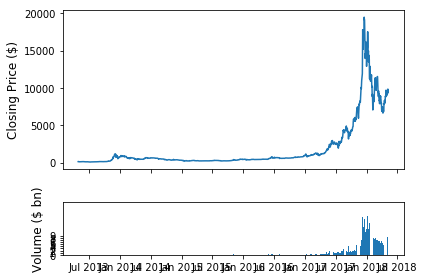

In [38]:
show_plot(btc_data, tag='BTC')


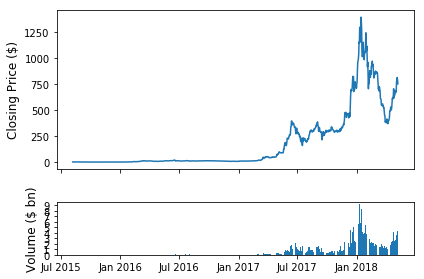

In [39]:
show_plot(eth_data, tag='ETH')



#### We will be defining couple of functions which will do following roles :

    * The next step is data preparation, which will include cleaning of the data and filling up missing points. 
    * Next step would be to try and merge bitcoin and ethereum channels.
    * Removing unnecessary columns and sort our data in ascending order based on the date
    * After that, we will be splitting the data into train and test data-set
    * Creating input samples and normalizing them between 0 and 1. 
    * Creating target outputs for the training and test sets and normalize them between 0 and 1.
    * Convert our data to numpy array to be consumed by our model.


* merge_data function includes the data from the provided date and drops any data before that date. 

In [11]:
def merge_data(a, b, from_date=merge_date):
  merged_data = pd.merge(a, b, on=['Date'])
  merged_data = merged_data[merged_data['Date'] >= from_date]
  return merged_data

* Next on, lets write a fucntion that calcultes the volatility and close_off_hig of each given coin in 24 hours

In [12]:
def add_volatility(data, coins=['BTC', 'ETH']):
  for coin in coins:
    # calculate the daily change
    kwargs = {coin + '_change': lambda x: (x[coin + '_Close'] - x[coin + '_Open']) / x[coin + '_Open'],
             coin + '_close_off_high': lambda x: 2*(x[coin + '_High'] - x[coin + '_Close']) / (x[coin + '_High'] - x[coin + '_Low']) - 1,
             coin + '_volatility': lambda x: (x[coin + '_High'] - x[coin + '_Low']) / (x[coin + '_Open'])}
    data = data.assign(**kwargs)
  return data

* Next function drops unnecessary columns and reverses the order of DataFrame based on decending dates.

In [13]:

def create_model_data(data):
  data = data[['Date']+[coin+metric for coin in ['BTC_', 'ETH_'] for metric in ['Close','Volume']]]
  data = data.sort_values(by='Date')
  return data

* This function splits the data into training_set and test_set based on the given training_size


In [14]:
def split_data(data, training_size=0.8):
  return data[:int(training_size*len(data))], data[int(training_size*len(data)):]

* This function will create input array X from the given dataset and will normalize 'Close' and 'Volume' between 0 and 1


In [15]:
def create_inputs(data, coins=['BTC', 'ETH'], window_len=window_len):

  norm_cols = [coin + metric for coin in coins for metric in ['_Close', '_Volume']]
  inputs = []
  for i in range(len(data) - window_len):
    temp_set = data[i:(i + window_len)].copy()
    inputs.append(temp_set)
    for col in norm_cols:
      inputs[i].loc[:, col] = inputs[i].loc[:, col] / inputs[i].loc[:, col].iloc[0] - 1  
  return inputs

* This function will create the labels array for our training and validation and normalize it between 0 and 1
 

In [16]:
def create_outputs(data, coin, window_len=window_len):
  return (data[coin + '_Close'][window_len:].values / data[coin + '_Close'][:-window_len].values) - 1

*   This function will convert list of inputs to a numpy array



In [17]:
def to_array(data):
  x = [np.array(data[i]) for i in range (len(data))]
  return np.array(x)



* This function will build 3 layered RNN model with LSTM cells with dropouts after each LSTM layer 
  and finally a dense layer to produce the output using keras' sequential model.


In [18]:
def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):

  model = Sequential()
  model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(Activation(activ_func))
  model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
  model.summary()
  return model

In [19]:
def date_labels():
  last_date = market_data.iloc[0, 0]
  date_list = [last_date - datetime.timedelta(days=x) for x in range(len(X_test))]
  return[date.strftime('%m/%d/%Y') for date in date_list][::-1]

In [20]:
def plot_results(history, model, Y_target, coin):
  plt.figure(figsize=(25, 20))
  plt.subplot(311)
  plt.plot(history.epoch, history.history['loss'], )
  plt.plot(history.epoch, history.history['val_loss'])
  plt.xlabel('Number of Epochs')
  plt.ylabel('Loss')
  plt.title(coin + ' Model Loss')
  plt.legend(['Training', 'Test'])

  plt.subplot(312)
  plt.plot(Y_target)
  plt.plot(model.predict(X_train))
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title(coin + ' Single Point Price Prediction on Training Set')
  plt.legend(['Actual','Predicted'])

  ax1 = plt.subplot(313)
  plt.plot(test_set[coin + '_Close'][window_len:].values.tolist())
  plt.plot(((np.transpose(model.predict(X_test)) + 1) * test_set[coin + '_Close'].values[:-window_len])[0])
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title(coin + ' Single Point Price Prediction on Test Set')
  plt.legend(['Actual','Predicted'])
  
  date_list = date_labels()
  ax1.set_xticks([x for x in range(len(date_list))])
  for label in ax1.set_xticklabels([date for date in date_list], rotation='vertical')[::2]:
    label.set_visible(False)

  plt.show()

* Merging the data and creating the model data

In [21]:
market_data = merge_data(btc_data, eth_data)
model_data = create_model_data(market_data)


* Splitting the data into train_set and test_set

In [22]:
train_set, test_set = split_data(model_data)



In [23]:
model_data.head()

,Date,BTC_Close,BTC_Volume,ETH_Close,ETH_Volume
857,2016-01-01,434.33,36278900.0,0.948024,206062
856,2016-01-02,433.44,30096600.0,0.937124,255504
855,2016-01-03,430.01,39633800.0,0.971905,407632
854,2016-01-04,433.09,38477500.0,0.954480,346245
853,2016-01-05,431.96,34522600.0,0.950176,219833


* Now let’s build our LSTM-RNN model. In this model I will be using 3 layers of LSTM with 512 neurons per layer followed by 0.25 Dropout after each LSTM layer to prevent over-fitting and finally a Dense layer to produce our outputs.

In [24]:
train_set = train_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

X_train = create_inputs(train_set)
Y_train_btc = create_outputs(train_set, coin='BTC')
X_test = create_inputs(test_set)
Y_test_btc = create_outputs(test_set, coin='BTC')

Y_train_eth = create_outputs(train_set, coin='ETH')
Y_test_eth = create_outputs(test_set, coin='ETH')

X_train, X_test = to_array(X_train), to_array(X_test)

print (np.shape(X_train), np.shape(X_test), np.shape(Y_train_btc), np.shape(Y_test_btc))
print (np.shape(X_train), np.shape(X_test), np.shape(Y_train_eth), np.shape(Y_test_eth))

(683, 3, 4) (169, 3, 4) (683,) (169,)
(683, 3, 4) (169, 3, 4) (683,) (169,)


* Now it’s time for training our model on the data that we have collected


In [25]:
# clean up the memory
gc.collect()
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
btc_model = build_model(X_train, output_size=1, neurons=neurons)
# train model on data
btc_history = btc_model.fit(X_train, Y_train_btc, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test_btc), shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 3, 1024)           4214784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 1024)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 1024)           8392704   
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 1024)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 3, 1024)           8392704   
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 1024)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1024)              8392704   
__________

683/683 [==============================] - 7s 10ms/step - loss: 0.0015 - mean_absolute_error: 0.0266 - val_loss: 0.0040 - val_mean_absolute_error: 0.0470
Epoch 41/50
683/683 [==============================] - 7s 10ms/step - loss: 0.0014 - mean_absolute_error: 0.0255 - val_loss: 0.0041 - val_mean_absolute_error: 0.0470
Epoch 42/50
683/683 [==============================] - 7s 10ms/step - loss: 0.0014 - mean_absolute_error: 0.0256 - val_loss: 0.0040 - val_mean_absolute_error: 0.0473
Epoch 43/50
683/683 [==============================] - 7s 10ms/step - loss: 0.0014 - mean_absolute_error: 0.0257 - val_loss: 0.0040 - val_mean_absolute_error: 0.0465
Epoch 44/50
683/683 [==============================] - 7s 10ms/step - loss: 0.0014 - mean_absolute_error: 0.0255 - val_loss: 0.0040 - val_mean_absolute_error: 0.0469
Epoch 45/50
683/683 [==============================] - 7s 10ms/step - loss: 0.0015 - mean_absolute_error: 0.0257 - val_loss: 0.0040 - val_mean_absolute_error: 0.0469
Epoch 46/50
683/

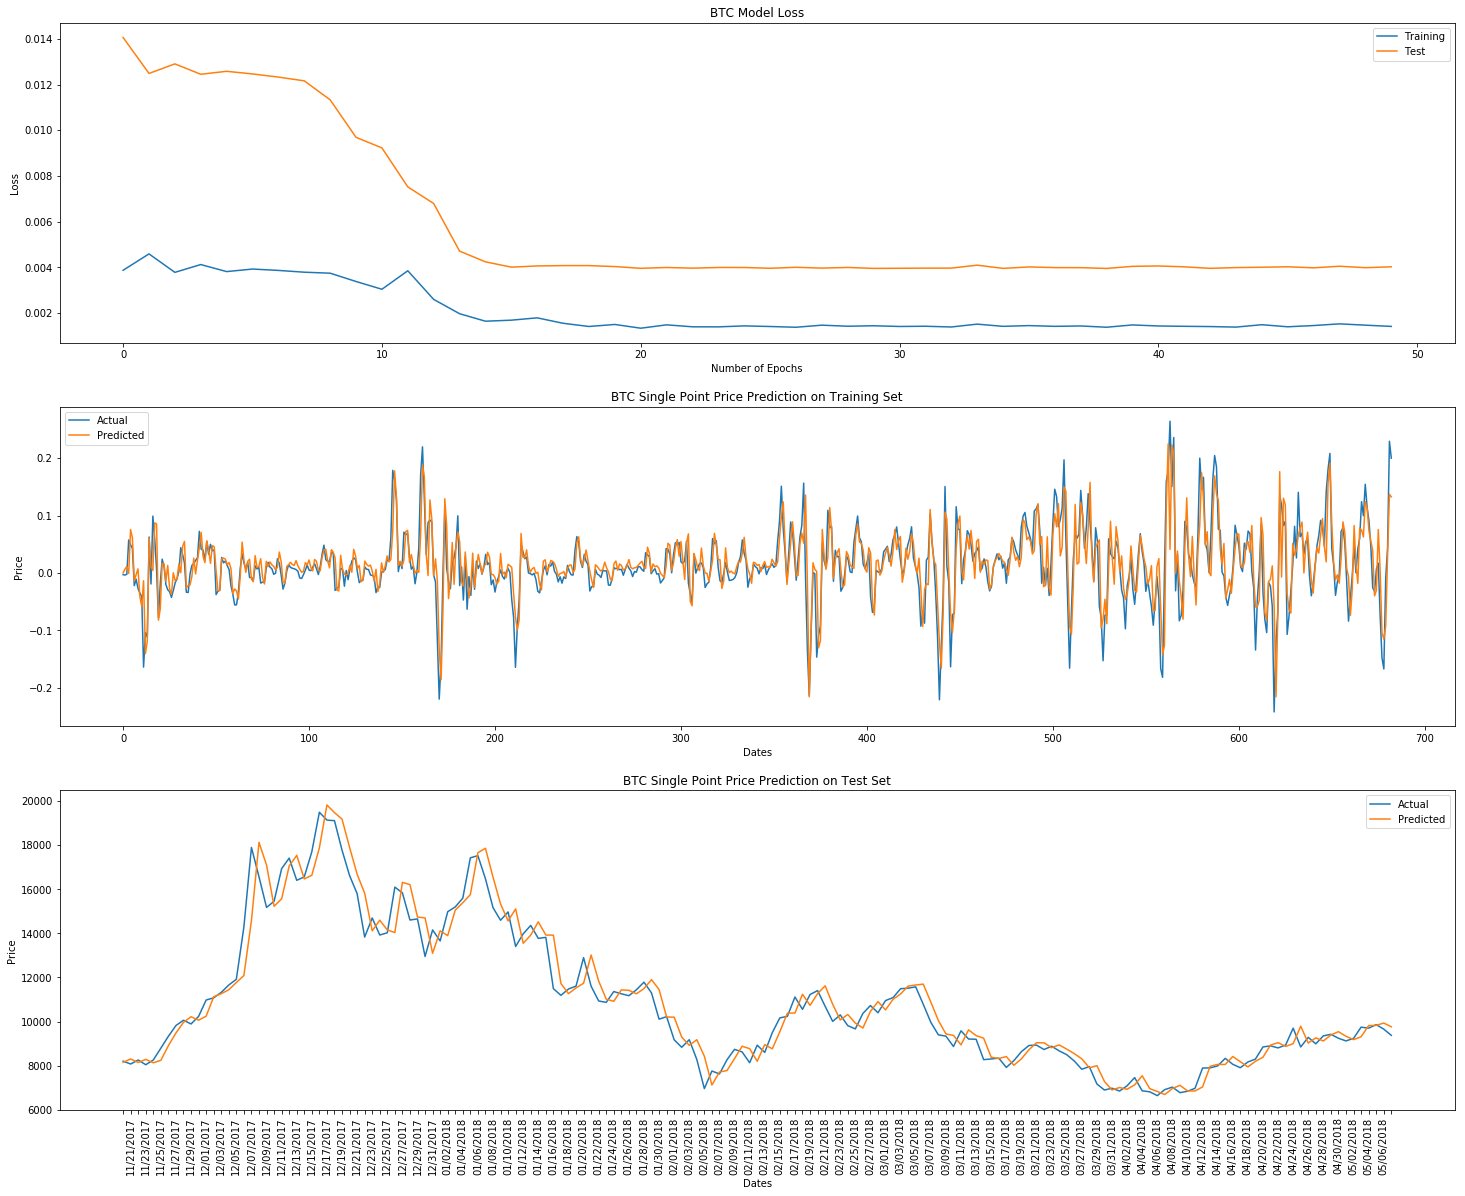

In [29]:
plot_results(btc_history, btc_model, Y_train_btc, coin='BTC')

In [27]:
# clean up the memory
gc.collect()

# random seed for reproducibility
np.random.seed(202)

# initialise model architecture
eth_model = build_model(X_train, output_size=1, neurons=neurons)

# train model on data
eth_history = eth_model.fit(X_train, Y_train_eth, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test_eth), shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 3, 1024)           4214784   
_________________________________________________________________
dropout_5 (Dropout)          (None, 3, 1024)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 3, 1024)           8392704   
_________________________________________________________________
dropout_6 (Dropout)          (None, 3, 1024)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 3, 1024)           8392704   
_________________________________________________________________
dropout_7 (Dropout)          (None, 3, 1024)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 1024)              8392704   
__________

683/683 [==============================] - 8s 12ms/step - loss: 0.0059 - mean_absolute_error: 0.0506 - val_loss: 0.0048 - val_mean_absolute_error: 0.0521
Epoch 41/50
683/683 [==============================] - 8s 12ms/step - loss: 0.0057 - mean_absolute_error: 0.0504 - val_loss: 0.0048 - val_mean_absolute_error: 0.0522
Epoch 42/50
683/683 [==============================] - 8s 12ms/step - loss: 0.0058 - mean_absolute_error: 0.0510 - val_loss: 0.0047 - val_mean_absolute_error: 0.0513
Epoch 43/50
683/683 [==============================] - 8s 12ms/step - loss: 0.0056 - mean_absolute_error: 0.0503 - val_loss: 0.0048 - val_mean_absolute_error: 0.0517
Epoch 44/50
683/683 [==============================] - 8s 12ms/step - loss: 0.0057 - mean_absolute_error: 0.0503 - val_loss: 0.0047 - val_mean_absolute_error: 0.0517
Epoch 45/50
683/683 [==============================] - 8s 11ms/step - loss: 0.0057 - mean_absolute_error: 0.0505 - val_loss: 0.0047 - val_mean_absolute_error: 0.0522
Epoch 46/50
683/

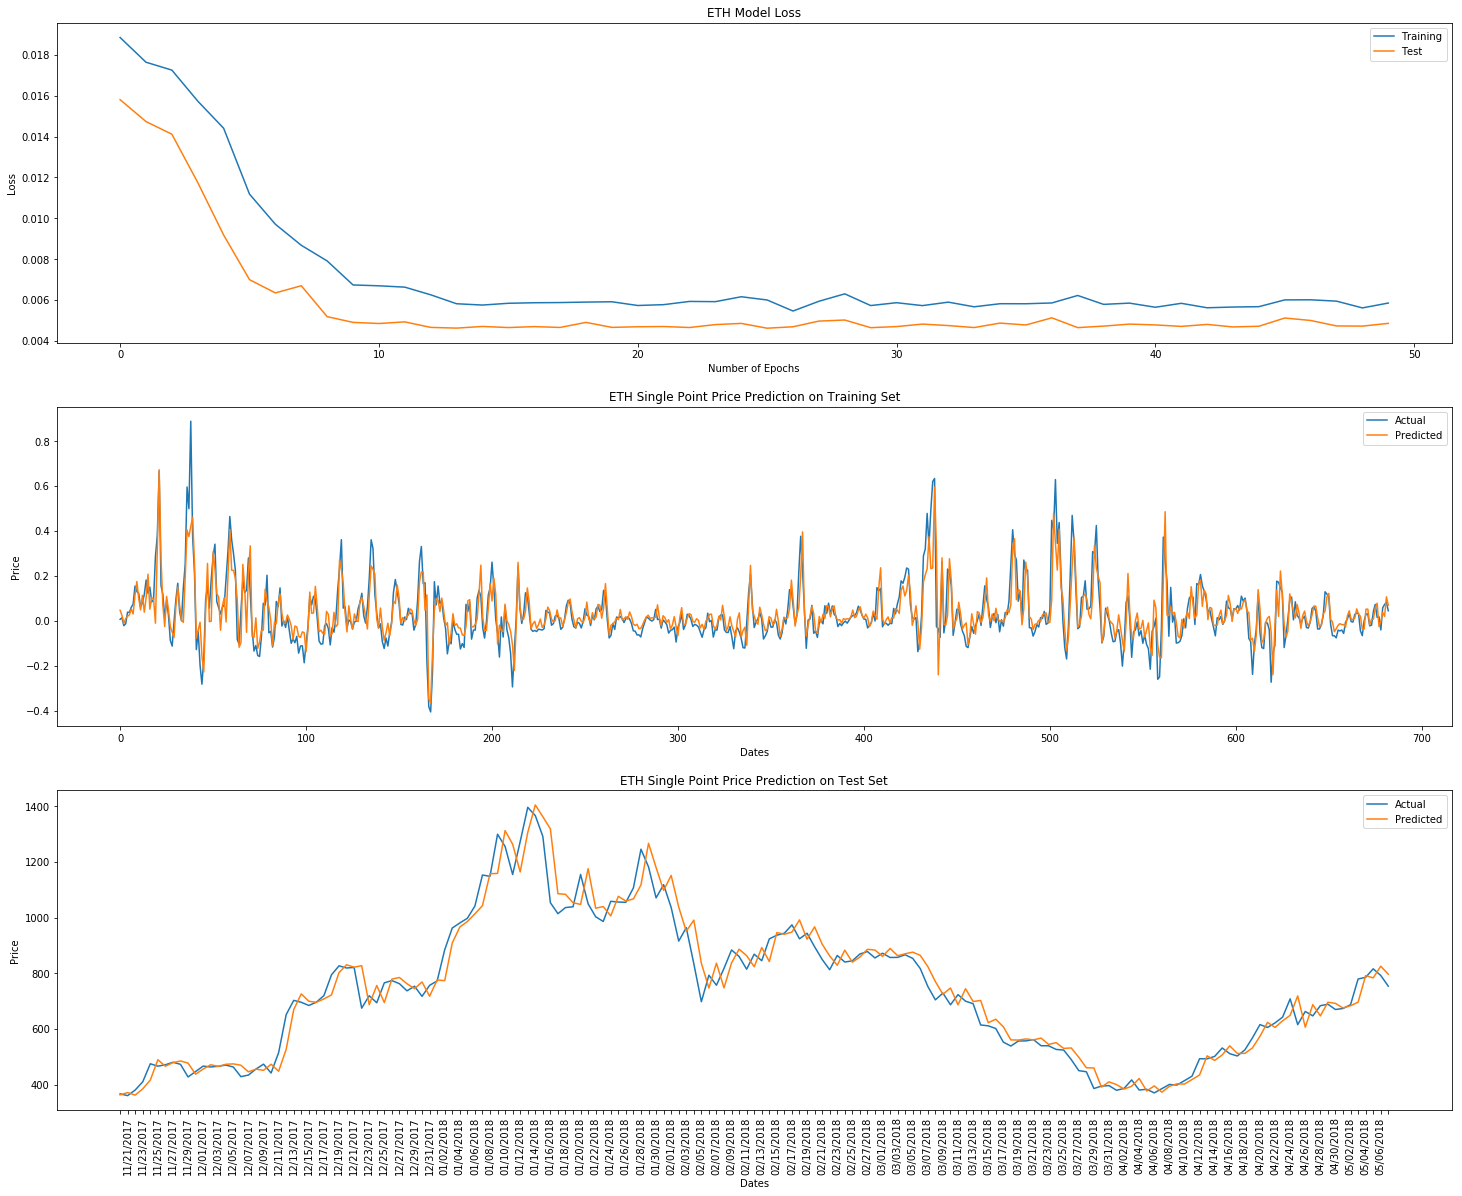

In [28]:
plot_results(eth_history, eth_model, Y_train_eth, coin='ETH')

# As can be seen from the above plot, what appears to be the perfect prediction is the LSTM model tracking the previous day price as can be seen in the comparison plots of actual and predicted lines. Hence these two different sources point to the same conclusion that LSTM models if used for actual trading than has to be fed large amount of data as well as optimizing architecture and hyper-parameters for a start. I would continue improving this model by making it run on huge amounts of data in the future. 
